In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import OneHotEncoder


In [123]:
df = pd.read_csv("data/topologies.csv", names=["Topology", "QueueType", "QueuePosition", "BuffersPerRouter", "ArbitratorType", "Algorithm", "Generatrixs", "DataLength", "ALMs", "Registers", "Frequency"])


In [124]:
oneHotEncoders = dict()
columnsToEncode = ["Topology", "QueueType", "QueuePosition", "ArbitratorType", "Algorithm"]

enc = OneHotEncoder()

enc.fit(df[columnsToEncode])

df = pd.concat([df,pd.DataFrame.sparse.from_spmatrix(enc.transform(df[columnsToEncode]))], axis=1)


In [125]:
c = -1
for i in range(len(enc.categories_)):
    for j in range(len(enc.categories_[i])):
        c += 1
        df.rename({c: enc.categories_[i][j]}, axis=1, inplace=True)


In [126]:
df.drop(columnsToEncode, inplace=True, axis=1)


In [127]:
workm = df.drop(["DataLength", "pointer", "rear", "round_robin", "xy", "Torus", "ga"], axis=1)[df["Mesh"] == 1]

temp = workm['Generatrixs'].str.split(', ', n=1, expand=True).astype('uint16')
workm['RoutersNumber'] = temp[temp.columns[1]]*temp[temp.columns[0]]
workm.drop(['Generatrixs'], axis=1, inplace=True)

del temp


In [128]:
workt = df.drop(["DataLength", "pointer", "rear", "round_robin", "xy", "Torus", "ga"], axis=1)[df["Torus"] == 1]

temp = workt['Generatrixs'].str.split(', ', n=1, expand=True).astype('uint16')
workt['RoutersNumber'] = temp[temp.columns[1]]*temp[temp.columns[0]]
workt.drop(['Generatrixs'], axis=1, inplace=True)

del temp


In [129]:
workc = df.drop(["DataLength", "pointer", "rear", "round_robin", "xy", "Torus", "ga"], axis=1)[df["Circulant"] == 1]

temp = workc['Generatrixs'].str.split(', ', n=5, expand=True).astype('uint16')
workc['RoutersNumber'] = temp.max(axis=1)
workc.drop(['Generatrixs'], axis=1, inplace=True)

del temp


In [130]:
work = pd.concat([workm, workt, workc])

del workm
del workt
del workc

work["BuffersNumber"] = work["BuffersPerRouter"]*work["RoutersNumber"]


Data ready

<Axes: >

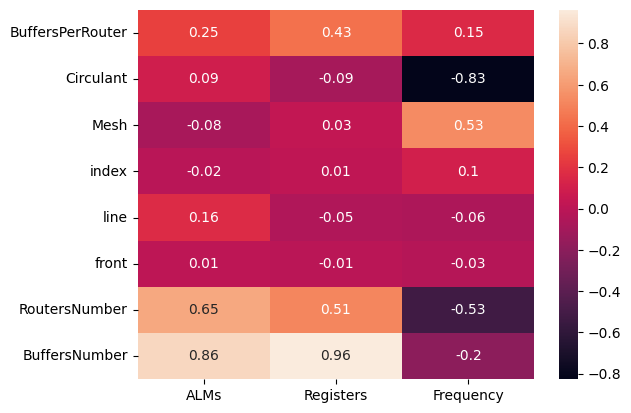

In [131]:
cor = work.corr()
cor.drop(["Mesh", "Circulant", "index", "line", "front", "BuffersNumber", "RoutersNumber", "BuffersPerRouter"], axis=1, inplace=True)
cor.drop(["ALMs", "Registers", "Frequency"], axis=0, inplace=True)
sb.heatmap(cor, annot=cor.apply(lambda x: x//0.01*0.01))


In [132]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error, r2_score


In [133]:
X = work.drop(["Registers", "ALMs", "Frequency"] ,axis=1)
y = work[["Registers", "ALMs", "Frequency"]]

xScaler = MinMaxScaler().fit(X)
rScaler = MinMaxScaler().fit(y[["Registers"]])
aScaler = MinMaxScaler().fit(y[["ALMs"]])
fScaler = MinMaxScaler().fit(y[["Frequency"]])

X = xScaler.transform(X)

y[["Registers"]] = rScaler.transform(y[["Registers"]])
y[["ALMs"]] = aScaler.transform(y[["ALMs"]])
y[["Frequency"]] = fScaler.transform(y[["Frequency"]])


/home/elgrush/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/home/elgrush/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/tmp/ipykernel_3516/2801834197.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[["Registers"]] = rScaler.transform(y[["Registers"]])
/tmp/ipykernel_3516/2801834197.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=228)

In [135]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [136]:
model = smf.ols(formula='Registers ~ Mesh + Circulant + index + line + front + BuffersNumber + BuffersPerRouter + RoutersNumber', data=work).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              Registers   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                 3.327e+04
Date:                 Вт, 25 мар 2025   Prob (F-statistic):               0.00
Time:                        00:05:16   Log-Likelihood:                -43563.
No. Observations:                4429   AIC:                         8.714e+04
Df Residuals:                    4420   BIC:                         8.720e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         3018.3168    346.032  

In [137]:
model = smf.ols(formula='ALMs ~ Mesh + Circulant + index + line + front + BuffersPerRouter  +  BuffersNumber + RoutersNumber', data=work).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                   ALMs   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                 1.022e+04
Date:                 Вт, 25 мар 2025   Prob (F-statistic):               0.00
Time:                        00:05:16   Log-Likelihood:                -44446.
No. Observations:                4429   AIC:                         8.891e+04
Df Residuals:                    4420   BIC:                         8.897e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -7902.8347    422.365  

In [138]:
model = smf.ols(formula='Frequency ~ Mesh + Circulant + index + line + front + BuffersPerRouter + BuffersNumber + RoutersNumber', data=work).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              Frequency   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     4541.
Date:                 Вт, 25 мар 2025   Prob (F-statistic):               0.00
Time:                        00:05:16   Log-Likelihood:                -14600.
No. Observations:                4429   AIC:                         2.922e+04
Df Residuals:                    4420   BIC:                         2.927e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          111.3385      0.500  

In [139]:
lrR = LinearRegression()
lrR.fit(X_train, y_train["Registers"])

lrA = LinearRegression()
lrA.fit(X_train, y_train["ALMs"])

lrF = LinearRegression()
lrF.fit(X_train, y_train["Frequency"])

rP = lrR.predict(X_test)
aP = lrA.predict(X_test)
fP = lrF.predict(X_test)

print("Registers MSE:", root_mean_squared_error(y_test["Registers"], rP), 'R2:', r2_score(y_test["Registers"], rP), '\n', [abs(i) for i in lrR.coef_]/sum([abs(i) for i in lrR.coef_])*100)
print("ALMs MSE:", root_mean_squared_error(y_test["ALMs"], aP), 'R2:', r2_score(y_test["ALMs"], aP), '\n',[abs(i) for i in lrA.coef_]/sum([abs(i) for i in lrA.coef_])*100)
print("Frequency MSE:", root_mean_squared_error(y_test["Frequency"], fP), 'R2:', r2_score(y_test["Frequency"], fP), '\n', [abs(i) for i in lrF.coef_]/sum([abs(i) for i in lrF.coef_])*100)


Registers MSE: 0.023360659458680468 R2: 0.9845934175335982 
 [ 4.49695577  1.41916019  4.25033628  0.53055875  1.57648486  0.48792072
  5.82619154 81.41239189]
ALMs MSE: 0.04952286395926108 R2: 0.9506668941926908 
 [ 2.58055321  1.33196343  4.06896342  2.04397194  5.6763641   0.86358166
 13.34916629 70.08543595]
Frequency MSE: 0.05868007788094765 R2: 0.9063438777593654 
 [35.08903895 33.27818204  3.79120963  2.64375974  0.69017759  0.99700126
 17.56157045  5.94906033]


Сделаем поправку на ресурсы алгоритма и арбитера

In [140]:
arb2n = pd.read_csv('data/arbiter2n.csv', names=["TopLevelEntity", "Topology", "QueueType", "QueuePosition", "ArbitratorType", "Algorithm", "Generatrixs", "DataLength", "ALMsArb2n", "RegistersArb2n", "Frequency"], skiprows=1)
arb3n = pd.read_csv('data/arbiter3n.csv', names=["TopLevelEntity", "Topology", "QueueType", "QueuePosition", "ArbitratorType", "Algorithm", "Generatrixs", "DataLength", "ALMsArb3n", "RegistersArb3n", "Frequency"], skiprows=1)
arb4n = pd.read_csv('data/arbiter4n.csv', names=["TopLevelEntity", "Topology", "QueueType", "QueuePosition", "ArbitratorType", "Algorithm", "Generatrixs", "DataLength", "ALMsArb4n", "RegistersArb4n", "Frequency"], skiprows=1)
alg = pd.read_csv('data/algorithm.csv', names=["TopLevelEntity", "Topology", "QueueType", "QueuePosition", "ArbitratorType", "Algorithm", "Generatrixs", "DataLength", "ALMsAlg", "RegistersAlg", "Frequency"], skiprows=1)
df = pd.read_csv("data/topologies.csv", names=["Topology", "QueueType", "QueuePosition", "BuffersPerRouter", "ArbitratorType", "Algorithm", "Generatrixs", "DataLength", "ALMs", "Registers", "Frequency"])


In [141]:
df = df.merge(arb2n[["ALMsArb2n", "RegistersArb2n", "DataLength"]], on=["DataLength"])
df = df.merge(arb3n[["ALMsArb3n", "RegistersArb3n", "DataLength"]], on=["DataLength"])
df = df.merge(arb4n[["ALMsArb4n", "RegistersArb4n", "DataLength"]], on=["DataLength"])
df = df.merge(alg[["ALMsAlg", "RegistersAlg", "DataLength", "Algorithm", "Topology"]], on=["DataLength", "Algorithm", "Topology"])


In [142]:
oneHotEncoders = dict()
columnsToEncode = ["Topology", "QueueType", "QueuePosition", "ArbitratorType", "Algorithm"]

enc = OneHotEncoder()

enc.fit(df[columnsToEncode])

df = pd.concat([df,pd.DataFrame.sparse.from_spmatrix(enc.transform(df[columnsToEncode]))], axis=1)


In [143]:
c = -1
for i in range(len(enc.categories_)):
    for j in range(len(enc.categories_[i])):
        c += 1
        df.rename({c: enc.categories_[i][j]}, axis=1, inplace=True)


In [144]:
df.drop(columnsToEncode, inplace=True, axis=1)


In [145]:
works = df.drop(["DataLength", "pointer", "rear", "round_robin", "xy", "Torus", "ga"], axis=1)[df["Circulant"] == 0]

temp = works['Generatrixs'].str.split(', ', n=1, expand=True).astype('uint16')
works["gen1"] = temp[temp.columns[0]]
works["gen2"] = temp[temp.columns[1]]
works['RoutersNumber'] = temp[temp.columns[1]]*temp[temp.columns[0]]
works.drop(['Generatrixs'], axis=1, inplace=True)

del temp


In [146]:
workc = df.drop(["DataLength", "pointer", "rear", "round_robin", "xy", "Torus", "ga"], axis=1)[df["Circulant"] == 1]

temp = workc['Generatrixs'].str.split(', ', n=5, expand=True).astype('uint16')
workc["gen1"] = temp[temp.columns[0]]
workc["gen2"] = temp[temp.columns[1]]
workc['RoutersNumber'] = temp.max(axis=1)
workc.drop(['Generatrixs'], axis=1, inplace=True)

del temp


In [147]:
work = pd.concat([works, workc])

del works
del workc

work["BuffersNumber"] = work["BuffersPerRouter"]*work["RoutersNumber"]


In [148]:
work["ALMs"] -= work["ALMsAlg"]*work["RoutersNumber"]
work["Registers"] -= work["RegistersAlg"]*work["RoutersNumber"]

work[work["Mesh"] == 0]["ALMs"] -= - work[work["Mesh"] == 0]["ALMsArb4n"]*work[work["Mesh"] == 0]["RoutersNumber"]
work[work["Mesh"] == 0]["Registers"] -= work[work["Mesh"] == 0]["RegistersArb4n"]*work[work["Mesh"] == 0]["RoutersNumber"]

work[work["Mesh"] == 1]["ALMs"] -= - work[work["Mesh"] == 1]["ALMsArb4n"]*((work["gen1"]-1)*(work["gen2"]-1))
work[work["Mesh"] == 1]["ALMs"] -= - work[work["Mesh"] == 1]["ALMsArb3n"]*((work["gen1"] + work["gen2"])*2 - 4 - 4)
work[work["Mesh"] == 1]["ALMs"] -= - work[work["Mesh"] == 1]["ALMsArb2n"]*4

work[work["Mesh"] == 1]["Registers"] -= - work[work["Mesh"] == 1]["RegistersArb4n"]*(work[work["Mesh"] == 1]["RoutersNumber"] - (work[work["Mesh"] == 1]["gen1"] + work[work["Mesh"] == 1]["gen2"])*2 + 4)
work[work["Mesh"] == 1]["Registers"] -= - work[work["Mesh"] == 1]["RegistersArb3n"]*((work[work["Mesh"] == 1]["gen1"] + work[work["Mesh"] == 1]["gen2"]) - 4 - 4)
work[work["Mesh"] == 1]["Registers"] -= - work[work["Mesh"] == 1]["RegistersArb2n"]*4

work.drop(columns=["gen1", "gen2", "ALMsArb2n", "RegistersArb2n", "ALMsArb3n", "RegistersArb3n", "ALMsArb4n", "RegistersArb4n", "ALMsAlg", "RegistersAlg"], inplace=True)

/tmp/ipykernel_3516/2958870765.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  work[work["Mesh"] == 0]["ALMs"] -= - work[work["Mesh"] == 0]["ALMsArb4n"]*work[work["Mesh"] == 0]["RoutersNumber"]
/tmp/ipykernel_3516/2958870765.py:4: Settin

Удаление закончено

<Axes: >

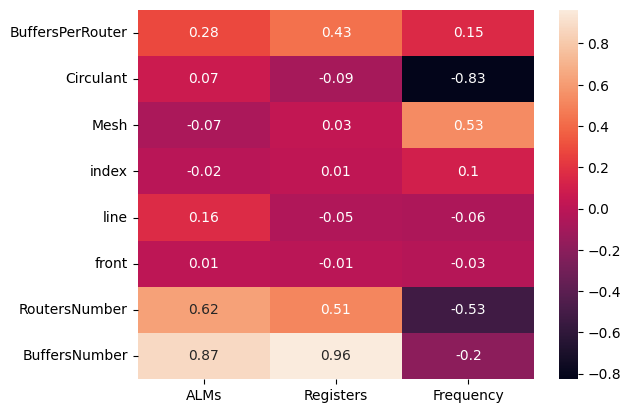

In [149]:
cor = work.corr()
cor.drop(["Mesh", "Circulant", "index", "line", "front", "BuffersNumber", "RoutersNumber", "BuffersPerRouter"], axis=1, inplace=True)
cor.drop(["ALMs", "Registers", "Frequency"], axis=0, inplace=True)
sb.heatmap(cor, annot=cor.apply(lambda x: x//0.01*0.01))


In [150]:
X = work.drop(["Registers", "ALMs", "Frequency"] ,axis=1)
y = work[["Registers", "ALMs", "Frequency"]]

xScaler = MinMaxScaler().fit(X)
rScaler = MinMaxScaler().fit(y[["Registers"]])
aScaler = MinMaxScaler().fit(y[["ALMs"]])
fScaler = MinMaxScaler().fit(y[["Frequency"]])

X = xScaler.transform(X)

y[["Registers"]] = rScaler.transform(y[["Registers"]])
y[["ALMs"]] = aScaler.transform(y[["ALMs"]])
y[["Frequency"]] = fScaler.transform(y[["Frequency"]])


/home/elgrush/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/home/elgrush/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/tmp/ipykernel_3516/2801834197.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[["Registers"]] = rScaler.transform(y[["Registers"]])
/tmp/ipykernel_3516/2801834197.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [151]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=228)

In [152]:
model = smf.ols(formula='Registers ~ Mesh + Circulant + index + line + front + BuffersNumber + BuffersPerRouter + RoutersNumber', data=work).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              Registers   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                 3.327e+04
Date:                 Вт, 25 мар 2025   Prob (F-statistic):               0.00
Time:                        00:05:19   Log-Likelihood:                -43563.
No. Observations:                4429   AIC:                         8.714e+04
Df Residuals:                    4420   BIC:                         8.720e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         3018.3168    346.032  

In [153]:
model = smf.ols(formula='ALMs ~ Mesh + Circulant + index + line + front + BuffersPerRouter  +  BuffersNumber + RoutersNumber', data=work).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                   ALMs   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     9729.
Date:                 Вт, 25 мар 2025   Prob (F-statistic):               0.00
Time:                        00:05:25   Log-Likelihood:                -44431.
No. Observations:                4429   AIC:                         8.888e+04
Df Residuals:                    4420   BIC:                         8.894e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -7659.5974    421.006  

In [154]:
model = smf.ols(formula='Frequency ~ Mesh + Circulant + index + line + front + BuffersPerRouter + BuffersNumber + RoutersNumber', data=work).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              Frequency   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     4541.
Date:                 Вт, 25 мар 2025   Prob (F-statistic):               0.00
Time:                        00:05:32   Log-Likelihood:                -14600.
No. Observations:                4429   AIC:                         2.922e+04
Df Residuals:                    4420   BIC:                         2.927e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          111.3385      0.500  

In [155]:
lrR = LinearRegression()
lrR.fit(X_train, y_train["Registers"])

lrA = LinearRegression()
lrA.fit(X_train, y_train["ALMs"])

lrF = LinearRegression()
lrF.fit(X_train, y_train["Frequency"])

rP = lrR.predict(X_test)
aP = lrA.predict(X_test)
fP = lrF.predict(X_test)

print("Registers MSE:", root_mean_squared_error(y_test["Registers"], rP), 'R2:', r2_score(y_test["Registers"], rP), '\n', [abs(i) for i in lrR.coef_]/sum([abs(i) for i in lrR.coef_])*100)
print("ALMs MSE:", root_mean_squared_error(y_test["ALMs"], aP), 'R2:', r2_score(y_test["ALMs"], aP), '\n',[abs(i) for i in lrA.coef_]/sum([abs(i) for i in lrA.coef_])*100)
print("Frequency MSE:", root_mean_squared_error(y_test["Frequency"], fP), 'R2:', r2_score(y_test["Frequency"], fP), '\n', [abs(i) for i in lrF.coef_]/sum([abs(i) for i in lrF.coef_])*100)


Registers MSE: 0.02391588585167242 R2: 0.9835471581863979 
 [ 4.54182939  1.47270898  4.24141084  0.5279551   1.58684802  0.47749121
  5.82021838 81.33153809]
ALMs MSE: 0.05073464840310512 R2: 0.9472020269932577 
 [ 2.93930942  1.0860471   4.09793758  2.13796541  5.7674064   0.89499891
 11.6777763  71.39855889]
Frequency MSE: 0.05940412684140359 R2: 0.9072163594772702 
 [35.6404807  33.30314766  3.7248546   2.70857282  0.66313674  1.13315896
 18.10326194  4.72338659]
